# Grouped By Graph Type CNN Model With Contamination Using Heatmaps With 3x3 Kernel

In [1]:
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import os

In [ ]:
# Common settings
img_height = 288
img_width = 512
batch_size = 32

# Get the project root directory
# Try to find project root by looking for "Heatmaps" folder
current_dir = os.getcwd()
project_root = current_dir

# Navigate up to find project root (where "Heatmaps" exists)
for _ in range(3):  # Check up to 3 levels up
    if os.path.exists(os.path.join(current_dir, "Heatmaps")):
        project_root = current_dir
        break
    parent = os.path.dirname(current_dir)
    if parent == current_dir:  # Reached filesystem root
        break
    current_dir = parent

# Base dataset path: Heatmaps/organized_by_graph_type (at project root)
base_dataset_path = os.path.join(project_root, "Heatmaps", "organized_by_graph_type")

# Print path for verification
print(f"Project root: {project_root}")
print(f"Base dataset path: {base_dataset_path}")

In [3]:
# Function to create your original CNN model
def create_model():
    model = models.Sequential([
        layers.Input(shape=(img_height, img_width, 3)),  # Color images

        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
# Train and evaluate one fold
def train_and_evaluate(dataset_name, fold, average_results):
    dataset_path = os.path.join(base_dataset_path, dataset_name)

    # Load datasets (RGB)
    train_ds = image_dataset_from_directory(
        dataset_path,
        validation_split=0.2,
        subset="training",
        seed=42,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        label_mode='binary'
    )

    val_ds = image_dataset_from_directory(
        dataset_path,
        validation_split=0.2,
        subset="validation",
        seed=42,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        label_mode='binary'
    )

    # # Convert RGB to grayscale
    # def convert_to_grayscale(image, label):
    #     image = tf.image.rgb_to_grayscale(image)
    #     return image, label
    #
    # train_ds = train_ds.map(convert_to_grayscale)
    # val_ds = val_ds.map(convert_to_grayscale)

    model = create_model()

    early_stop = EarlyStopping(
        monitor='val_accuracy',
        patience=3,
        restore_best_weights=True
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=10,
        callbacks=[early_stop]
    )

    # Plot accuracy
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{dataset_name} - Training vs Validation Accuracy - Fold {fold + 1}')
    plt.legend()
    plt.show()

    # Plot loss
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{dataset_name} - Training vs Validation Loss - Fold {fold + 1}')
    plt.legend()
    plt.show()

    # Evaluate on validation set
    y_true = []
    y_pred = []

    for images, labels in val_ds:
        preds = model.predict(images)
        y_true.extend(labels.numpy().astype(int))
        y_pred.extend((preds > 0.5).astype(int).flatten())

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Illiterate", "Literate"], yticklabels=["Illiterate", "Literate"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{dataset_name} - Confusion Matrix - Fold {fold + 1}')
    plt.show()

    # Track final epoch accuracy
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]

    average_results["train_accuracies"].append(final_train_acc)
    average_results["val_accuracies"].append(final_val_acc)

    print(f"Fold {fold + 1} Final Train Acc: {final_train_acc:.4f}, Final Val Acc: {final_val_acc:.4f}")


=== Running 5-fold CV for: bar ===
Found 779 files belonging to 2 classes.
Using 624 files for training.
Found 779 files belonging to 2 classes.
Using 155 files for validation.
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.5266 - loss: 204.4905 - val_accuracy: 0.4903 - val_loss: 0.6948
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.5420 - loss: 0.6902 - val_accuracy: 0.5548 - val_loss: 0.6948
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.5489 - loss: 0.6918 - val_accuracy: 0.5677 - val_loss: 0.6683
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.6586 - loss: 0.6297 - val_accuracy: 0.5871 - val_loss: 0.6705
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.6677 - loss: 0.6024 - val_accuracy: 0.6129 - val_loss: 0.6822
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.6899 - loss: 0.6491 - val_accuracy: 0.6000 - val_loss: 0.6767
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.

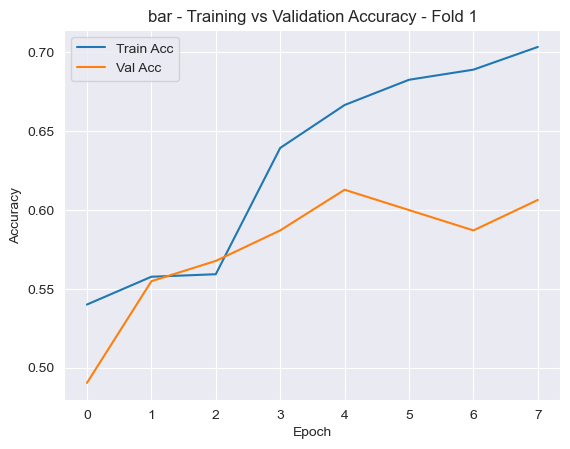

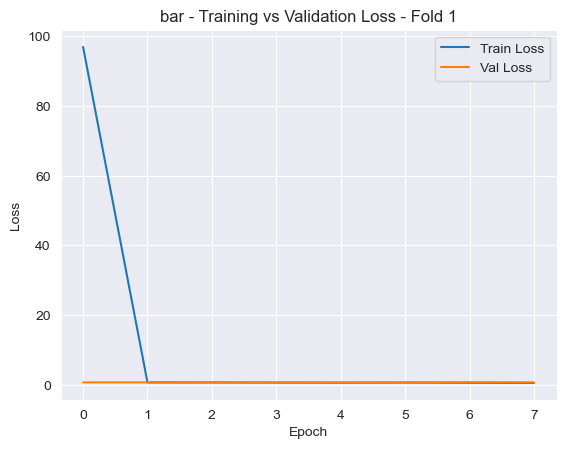

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


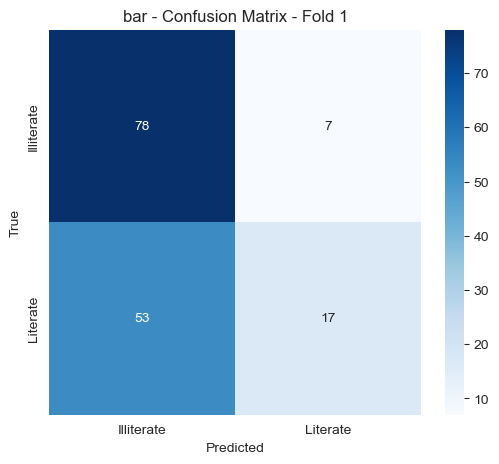

Fold 1 Final Train Acc: 0.7035, Final Val Acc: 0.6065
Found 779 files belonging to 2 classes.
Using 624 files for training.
Found 779 files belonging to 2 classes.
Using 155 files for validation.
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.5146 - loss: 229.4594 - val_accuracy: 0.5484 - val_loss: 0.6930
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.5607 - loss: 0.6915 - val_accuracy: 0.5484 - val_loss: 0.6924
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.5754 - loss: 0.6915 - val_accuracy: 0.5484 - val_loss: 0.6914
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.6090 - loss: 0.6884 - val_accuracy: 0.5484 - val_loss: 0.6902


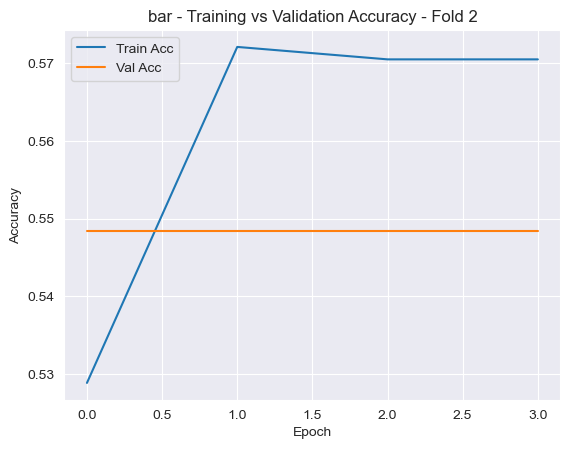

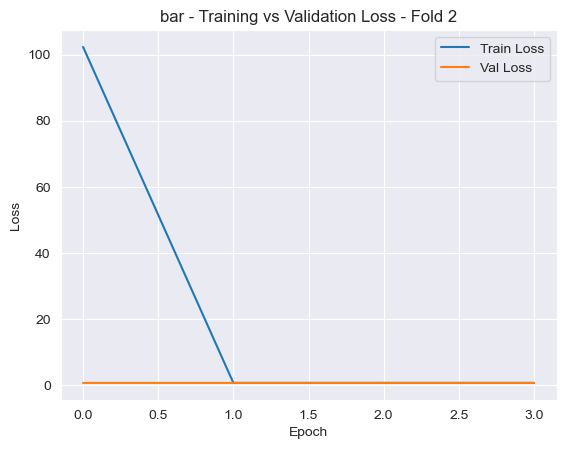

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


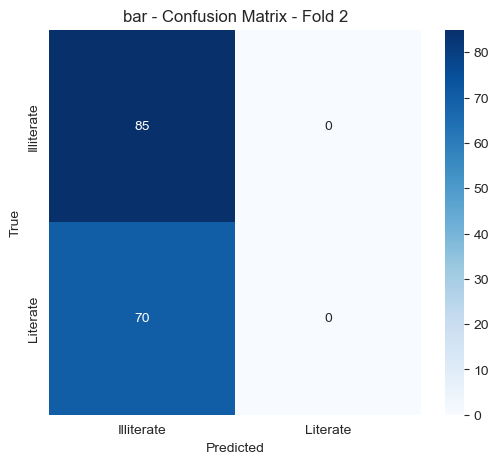

Fold 2 Final Train Acc: 0.5705, Final Val Acc: 0.5484
Found 779 files belonging to 2 classes.
Using 624 files for training.
Found 779 files belonging to 2 classes.
Using 155 files for validation.
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.5158 - loss: 482.8447 - val_accuracy: 0.5484 - val_loss: 1.2274
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.5250 - loss: 0.8215 - val_accuracy: 0.6258 - val_loss: 0.6668
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.5929 - loss: 0.6721 - val_accuracy: 0.6000 - val_loss: 0.6565
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.6303 - loss: 0.6306 - val_accuracy: 0.5484 - val_loss: 0.6925
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.5718 - loss: 0.6921 - val_accuracy: 0.5484 - val_loss: 0.6919


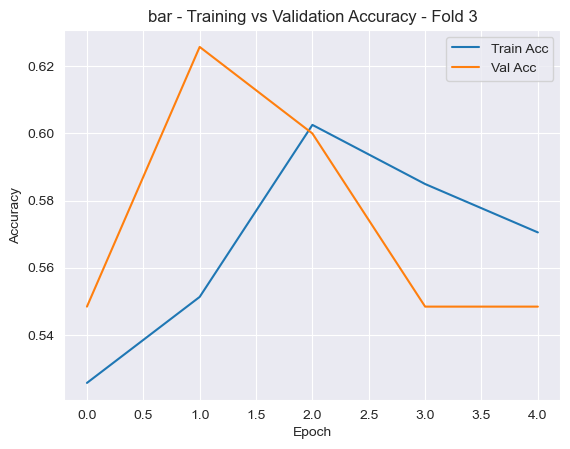

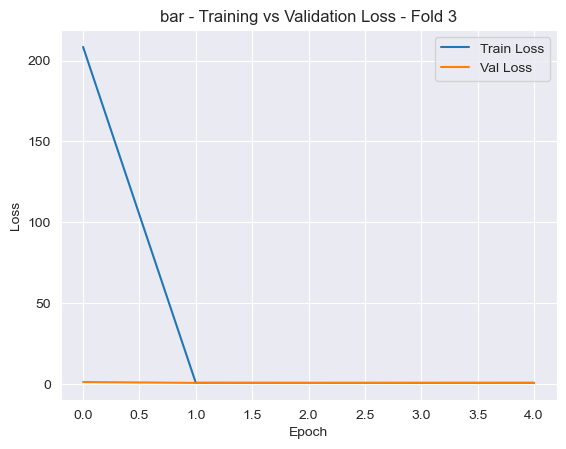

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


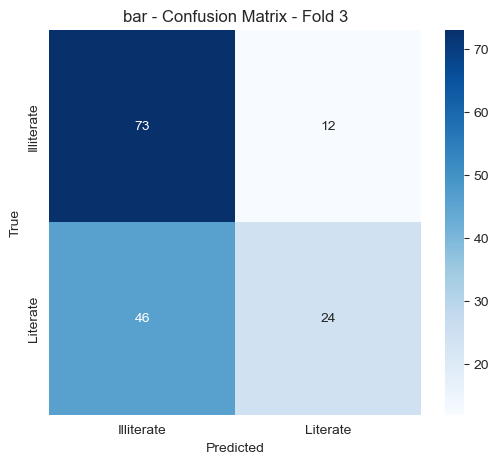

Fold 3 Final Train Acc: 0.5705, Final Val Acc: 0.5484
Found 779 files belonging to 2 classes.
Using 624 files for training.
Found 779 files belonging to 2 classes.
Using 155 files for validation.
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.4970 - loss: 246.6619 - val_accuracy: 0.6387 - val_loss: 0.6525
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.6032 - loss: 0.6551 - val_accuracy: 0.6194 - val_loss: 0.6256
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.6528 - loss: 0.6139 - val_accuracy: 0.5871 - val_loss: 0.6026
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.6824 - loss: 0.5588 - val_accuracy: 0.6323 - val_loss: 0.5944


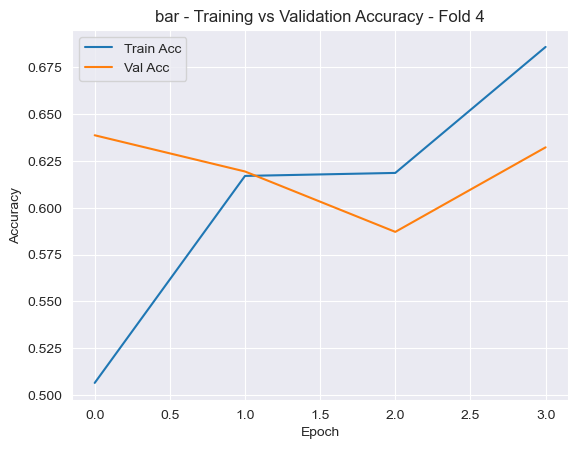

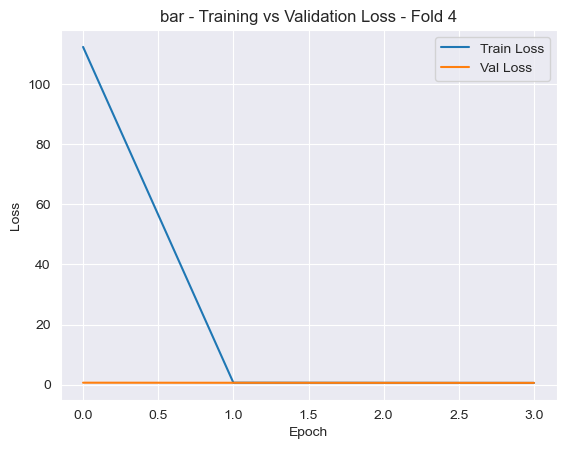

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


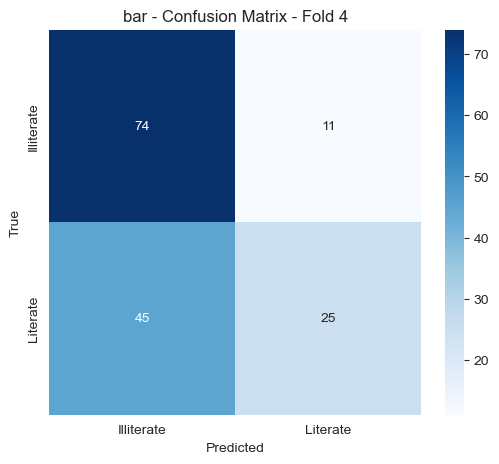

Fold 4 Final Train Acc: 0.6859, Final Val Acc: 0.6323
Found 779 files belonging to 2 classes.
Using 624 files for training.
Found 779 files belonging to 2 classes.
Using 155 files for validation.
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.5270 - loss: 438.2453 - val_accuracy: 0.5871 - val_loss: 0.6852
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.6180 - loss: 0.6584 - val_accuracy: 0.6323 - val_loss: 0.6466
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.6480 - loss: 0.6297 - val_accuracy: 0.6129 - val_loss: 0.6613
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.6780 - loss: 0.6495 - val_accuracy: 0.6065 - val_loss: 0.6733
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.7164 - loss: 0.5550 - val_accuracy: 0.5484 - val_loss: 0.6916


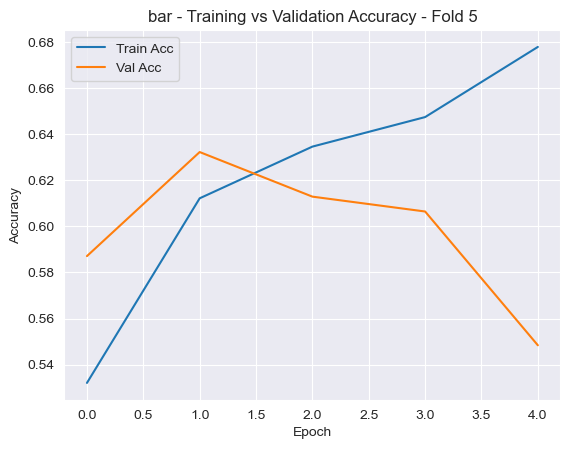

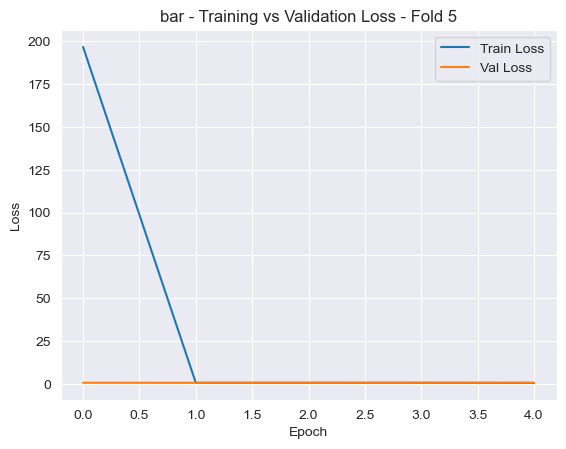

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


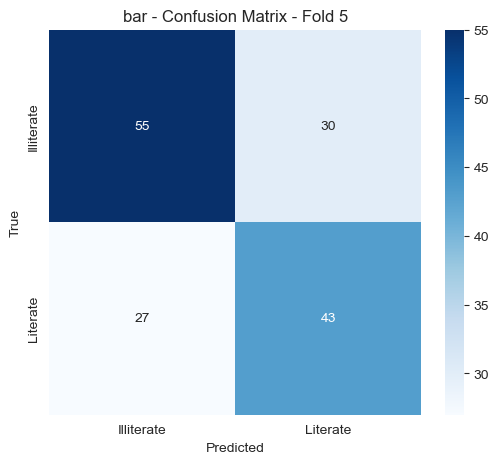

Fold 5 Final Train Acc: 0.6779, Final Val Acc: 0.5484

=== Running 5-fold CV for: line ===
Found 570 files belonging to 2 classes.
Using 456 files for training.
Found 570 files belonging to 2 classes.
Using 114 files for validation.
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5860 - loss: 545.9705 - val_accuracy: 0.4386 - val_loss: 1.1124
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.5285 - loss: 2.0136 - val_accuracy: 0.6053 - val_loss: 0.6342
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.5997 - loss: 0.6481 - val_accuracy: 0.6053 - val_loss: 0.6414
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.6195 - loss: 0.6224 - val_accuracy: 0.6316 - val_loss: 0.6273
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.6286 - loss: 0.6091 - val_accuracy: 0.6053 - val_loss: 0.6212
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.6616 - loss: 0.5969 - val_accuracy: 0.6228 - val_loss: 0.6294
Epoch 7/1

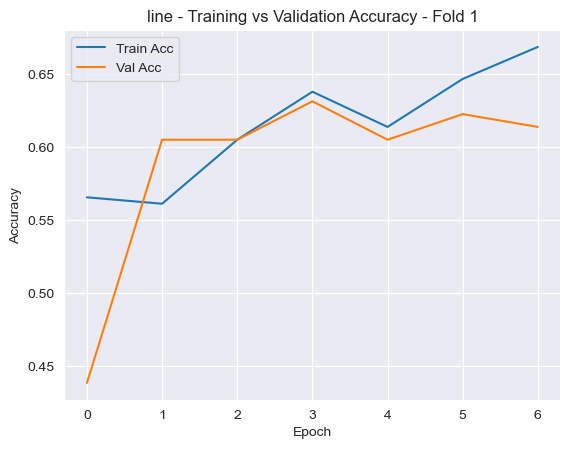

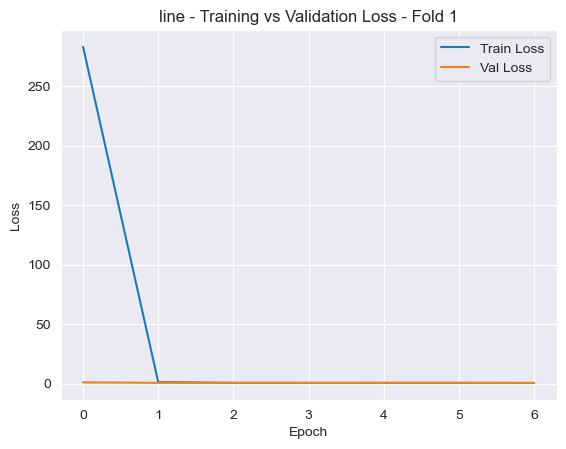

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


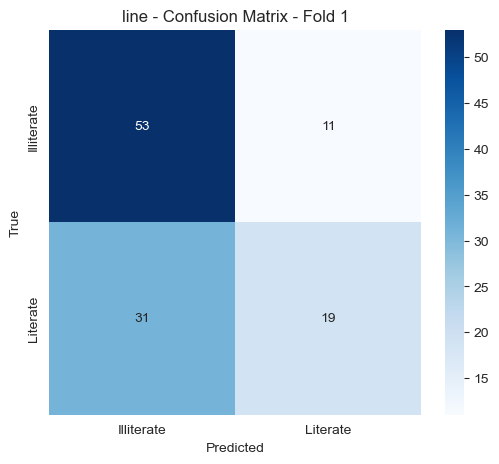

Fold 1 Final Train Acc: 0.6689, Final Val Acc: 0.6140
Found 570 files belonging to 2 classes.
Using 456 files for training.
Found 570 files belonging to 2 classes.
Using 114 files for validation.
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.4422 - loss: 543.8522 - val_accuracy: 0.4386 - val_loss: 2.0504
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.5474 - loss: 1.9244 - val_accuracy: 0.5789 - val_loss: 0.6693
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.6336 - loss: 0.6524 - val_accuracy: 0.6491 - val_loss: 0.6132
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.6761 - loss: 0.5877 - val_accuracy: 0.6754 - val_loss: 0.5971
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7251 - loss: 0.5337 - val_accuracy: 0.6053 - val_loss: 0.6082
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7153 - loss: 0.5192 - val_accuracy: 0.6228 - val_loss: 0.6212
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/s

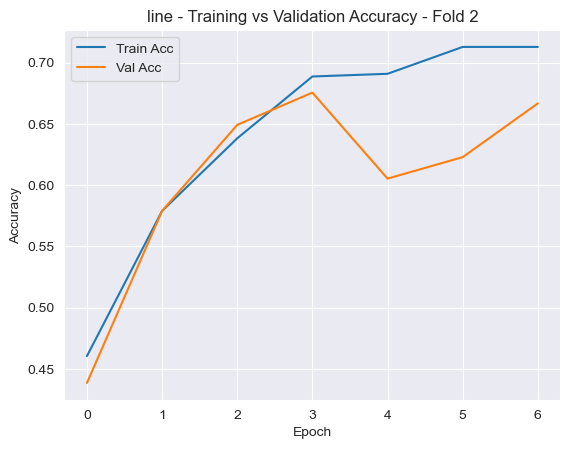

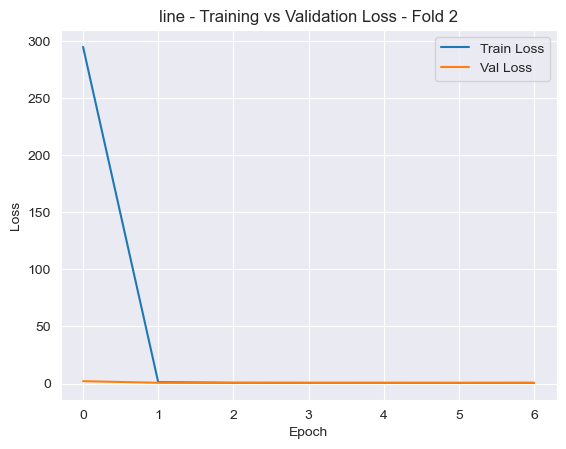

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


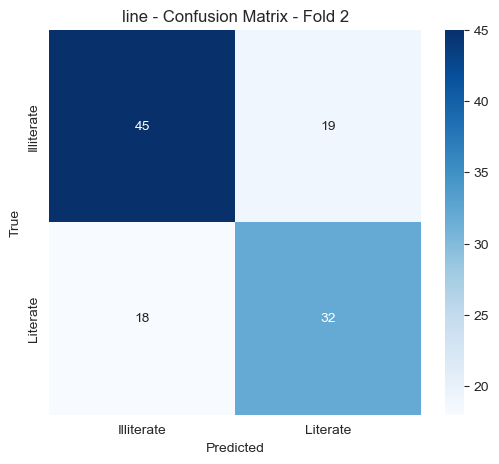

Fold 2 Final Train Acc: 0.7127, Final Val Acc: 0.6667
Found 570 files belonging to 2 classes.
Using 456 files for training.
Found 570 files belonging to 2 classes.
Using 114 files for validation.
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5566 - loss: 241.2599 - val_accuracy: 0.5965 - val_loss: 0.7826
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.5997 - loss: 0.8947 - val_accuracy: 0.5965 - val_loss: 0.6484
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.6776 - loss: 0.6159 - val_accuracy: 0.6228 - val_loss: 0.6332
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7028 - loss: 0.5746 - val_accuracy: 0.6316 - val_loss: 0.7002
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.7030 - loss: 0.5426 - val_accuracy: 0.6404 - val_loss: 0.7262
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7323 - loss: 0.5436 - val_accuracy: 0.6404 - val_loss: 0.6625
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/s

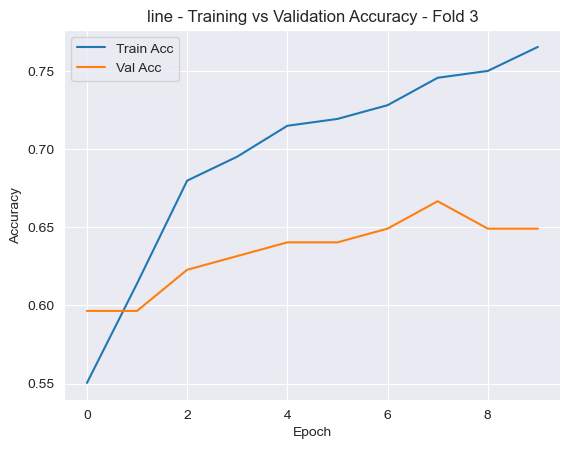

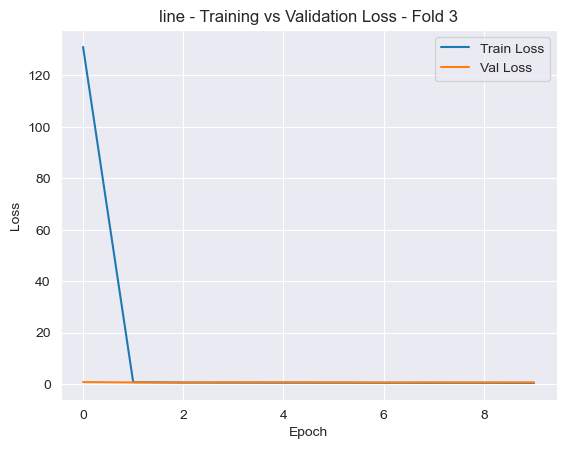

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


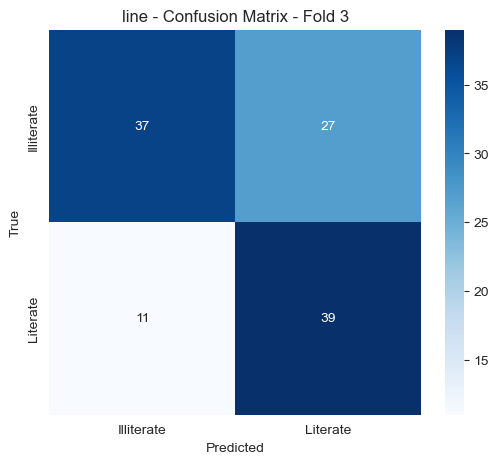

Fold 3 Final Train Acc: 0.7654, Final Val Acc: 0.6491
Found 570 files belonging to 2 classes.
Using 456 files for training.
Found 570 files belonging to 2 classes.
Using 114 files for validation.
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.4844 - loss: 733.1356 - val_accuracy: 0.5614 - val_loss: 1.0126
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.5816 - loss: 0.8465 - val_accuracy: 0.6228 - val_loss: 0.6591
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.5735 - loss: 0.6622 - val_accuracy: 0.5877 - val_loss: 0.6734
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.5959 - loss: 0.6728 - val_accuracy: 0.5965 - val_loss: 0.6297
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.6716 - loss: 0.5780 - val_accuracy: 0.6842 - val_loss: 0.6290
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.6964 - loss: 0.5335 - val_accuracy: 0.6579 - val_loss: 0.6385
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/s

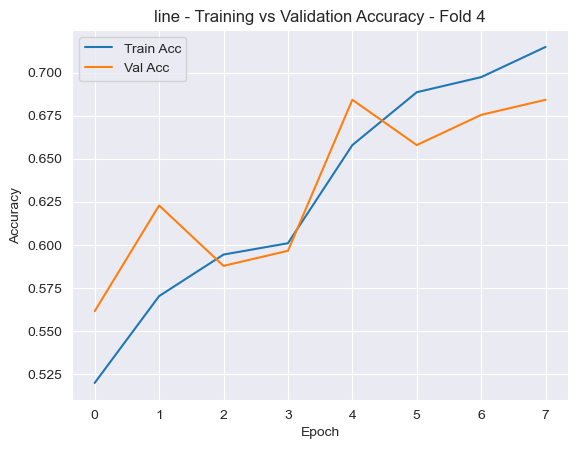

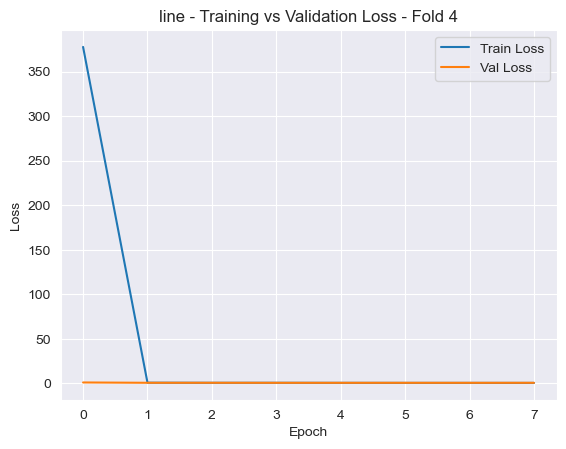

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


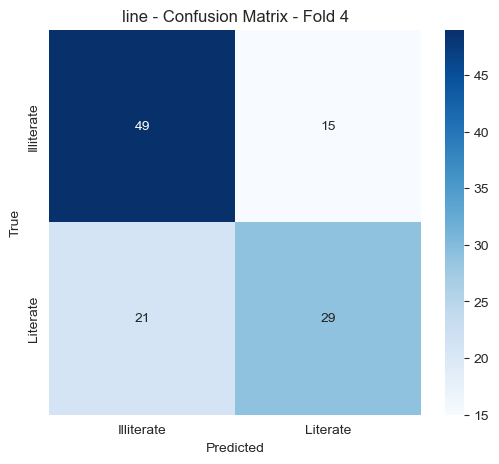

Fold 4 Final Train Acc: 0.7149, Final Val Acc: 0.6842
Found 570 files belonging to 2 classes.
Using 456 files for training.
Found 570 files belonging to 2 classes.
Using 114 files for validation.
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.4463 - loss: 752.9012 - val_accuracy: 0.4386 - val_loss: 3.2275
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.5195 - loss: 2.2755 - val_accuracy: 0.5614 - val_loss: 0.6616
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.5425 - loss: 0.6943 - val_accuracy: 0.6228 - val_loss: 0.6463
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.5942 - loss: 0.6239 - val_accuracy: 0.5877 - val_loss: 0.5956
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.6312 - loss: 0.5967 - val_accuracy: 0.6228 - val_loss: 0.5967
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.6115 - loss: 0.6016 - val_accuracy: 0.7281 - val_loss: 0.5572
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/s

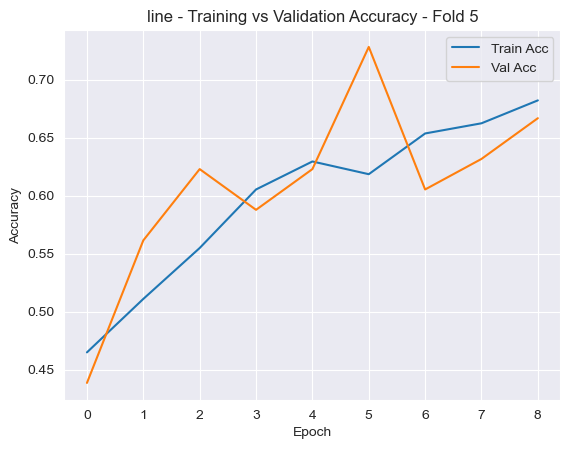

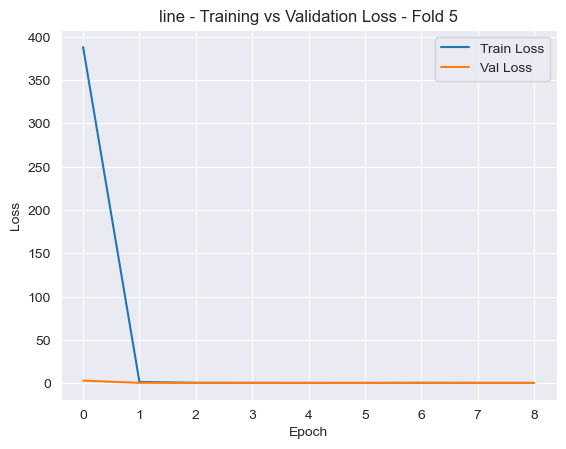

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


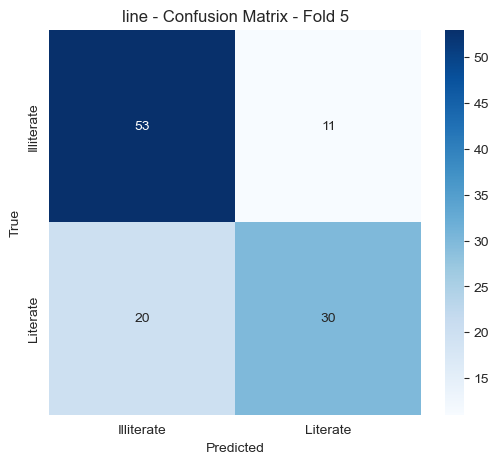

Fold 5 Final Train Acc: 0.6820, Final Val Acc: 0.6667

=== Running 5-fold CV for: pie ===
Found 150 files belonging to 2 classes.
Using 120 files for training.
Found 150 files belonging to 2 classes.
Using 30 files for validation.
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.5444 - loss: 321.3438 - val_accuracy: 0.4000 - val_loss: 58.6356
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5267 - loss: 46.9041 - val_accuracy: 0.5000 - val_loss: 7.5308
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.6973 - loss: 2.1581 - val_accuracy: 0.6000 - val_loss: 0.6159
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5865 - loss: 0.8153 - val_accuracy: 0.6333 - val_loss: 0.6488
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7629 - loss: 0.6070 - val_accuracy: 0.5000 - val_loss: 0.8329
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8204 - loss: 0.4774 - val_accuracy: 0.5667 - val_loss: 0.7279
Epoch 7/10
4/4 ━━━━━━━━━━━━

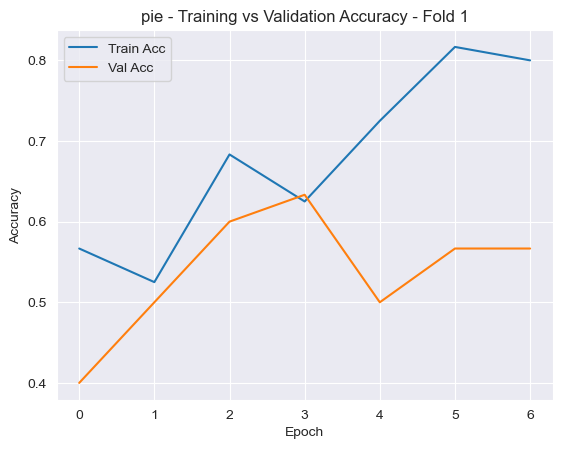

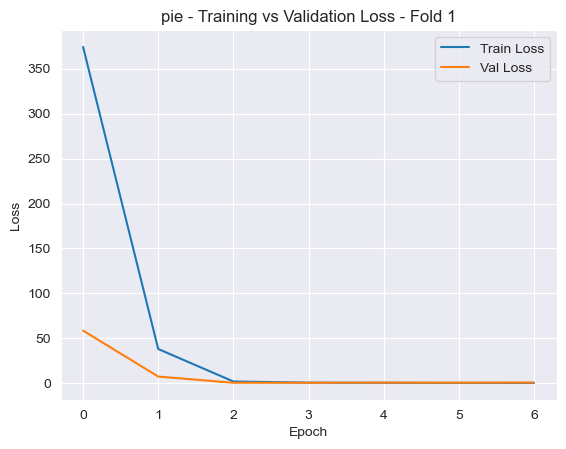

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


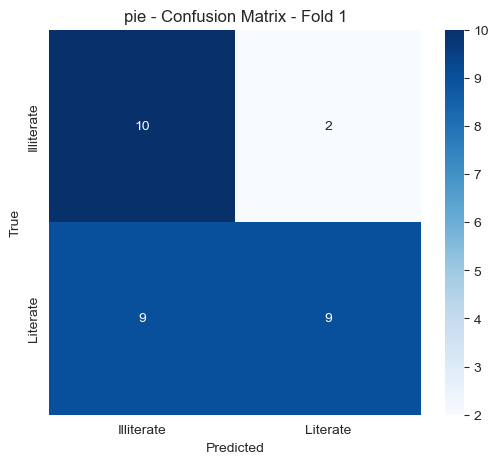

Fold 1 Final Train Acc: 0.8000, Final Val Acc: 0.5667
Found 150 files belonging to 2 classes.
Using 120 files for training.
Found 150 files belonging to 2 classes.
Using 30 files for validation.
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.5927 - loss: 778.4794 - val_accuracy: 0.4000 - val_loss: 182.9453
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5769 - loss: 71.6725 - val_accuracy: 0.4000 - val_loss: 8.9928
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5942 - loss: 7.6065 - val_accuracy: 0.4000 - val_loss: 3.3890
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7110 - loss: 1.6641 - val_accuracy: 0.7000 - val_loss: 0.6983
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7252 - loss: 0.6488 - val_accuracy: 0.6000 - val_loss: 0.5485
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7335 - loss: 0.5350 - val_accuracy: 0.5667 - val_loss: 0.6223
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7

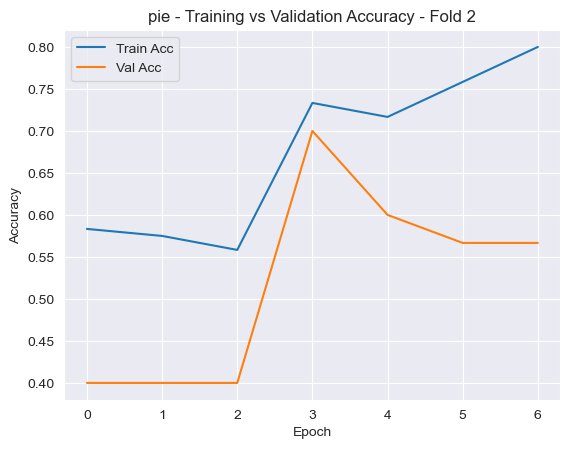

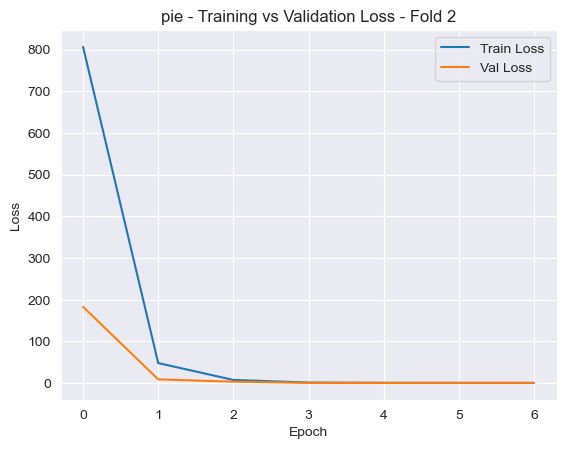

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


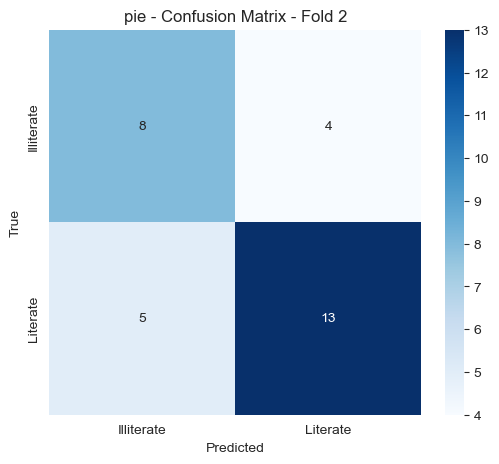

Fold 2 Final Train Acc: 0.8000, Final Val Acc: 0.5667
Found 150 files belonging to 2 classes.
Using 120 files for training.
Found 150 files belonging to 2 classes.
Using 30 files for validation.
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.5744 - loss: 1302.3951 - val_accuracy: 0.4000 - val_loss: 317.8605
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5054 - loss: 123.6709 - val_accuracy: 0.4000 - val_loss: 22.9293
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5940 - loss: 10.8531 - val_accuracy: 0.6000 - val_loss: 2.5661
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.4673 - loss: 5.8152 - val_accuracy: 0.4000 - val_loss: 5.4787
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5023 - loss: 2.8588 - val_accuracy: 0.4000 - val_loss: 1.7871
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5685 - loss: 1.0849 - val_accuracy: 0.4000 - val_loss: 0.8668


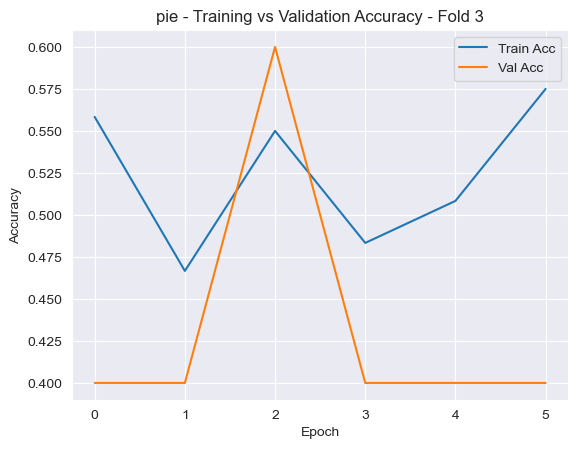

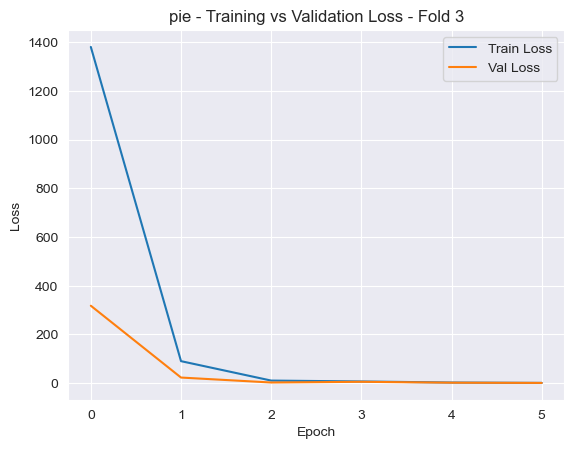

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step


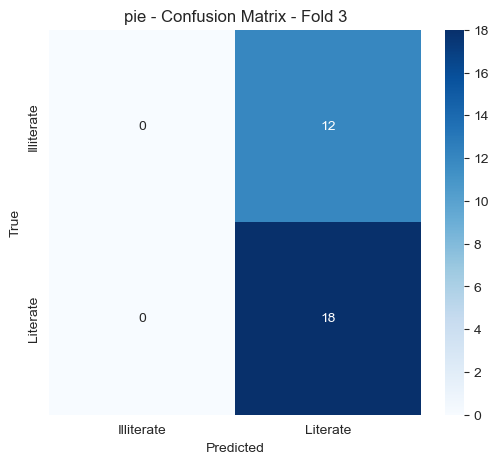

Fold 3 Final Train Acc: 0.5750, Final Val Acc: 0.4000
Found 150 files belonging to 2 classes.
Using 120 files for training.
Found 150 files belonging to 2 classes.
Using 30 files for validation.
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.4556 - loss: 649.1614 - val_accuracy: 0.6000 - val_loss: 74.8289
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5271 - loss: 62.9544 - val_accuracy: 0.6000 - val_loss: 5.0010
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.4106 - loss: 7.1206 - val_accuracy: 0.5000 - val_loss: 0.6864
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5008 - loss: 0.7212 - val_accuracy: 0.6000 - val_loss: 0.6603


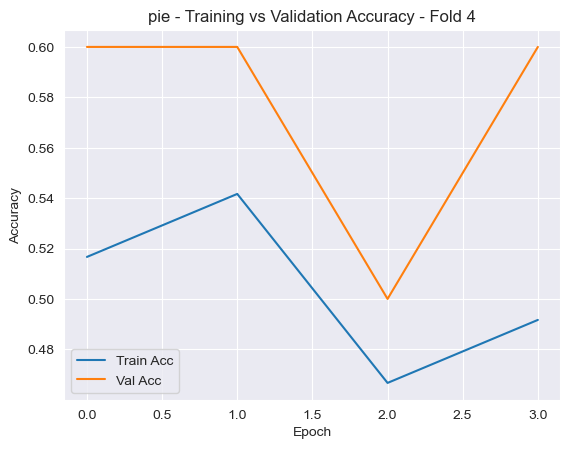

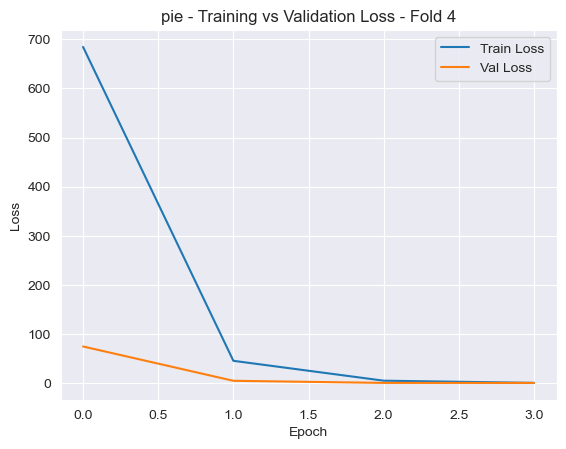

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


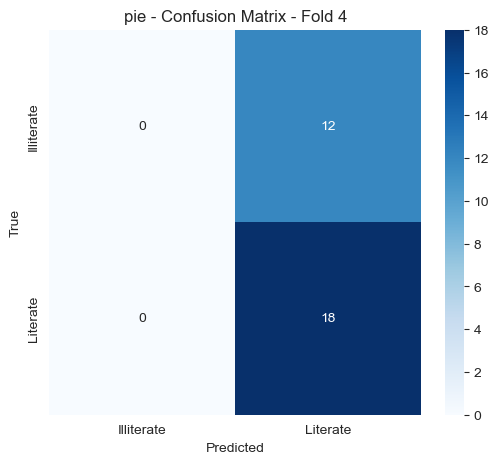

Fold 4 Final Train Acc: 0.4917, Final Val Acc: 0.6000
Found 150 files belonging to 2 classes.
Using 120 files for training.
Found 150 files belonging to 2 classes.
Using 30 files for validation.
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.5281 - loss: 526.4498 - val_accuracy: 0.4000 - val_loss: 103.4020
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5896 - loss: 47.0465 - val_accuracy: 0.4000 - val_loss: 17.8558
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.6658 - loss: 5.4655 - val_accuracy: 0.7000 - val_loss: 0.9585
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5758 - loss: 1.1715 - val_accuracy: 0.6333 - val_loss: 0.6338
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7965 - loss: 0.4617 - val_accuracy: 0.7333 - val_loss: 0.6000
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8246 - loss: 0.3681 - val_accuracy: 0.7667 - val_loss: 0.6335
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.

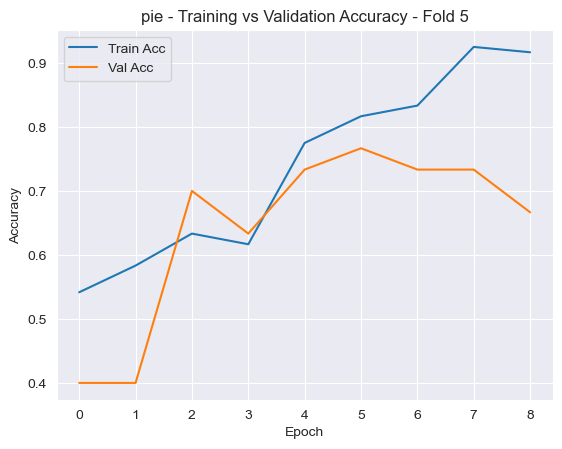

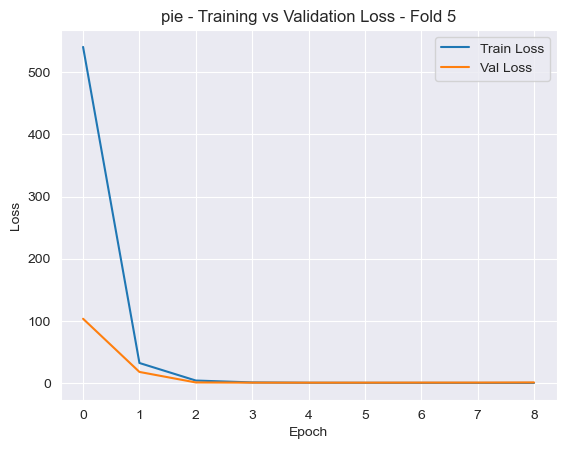

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


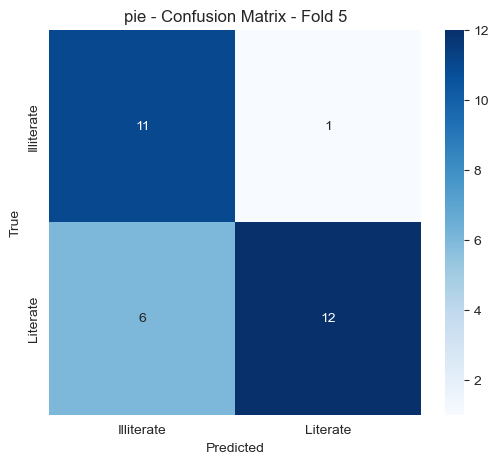

Fold 5 Final Train Acc: 0.9167, Final Val Acc: 0.6667


In [5]:
# Track results for all datasets
all_results = {}

# Perform training and collect fold-wise accuracies
for dataset_name in ["bar", "line", "pie"]:
    print(f"\n=== Running 5-fold CV for: {dataset_name} ===")
    average_results = {
        "train_accuracies": [],
        "val_accuracies": []
    }

    for fold in range(5):
        train_and_evaluate(dataset_name, fold, average_results)

    # Compute and store means
    all_results[dataset_name] = {
        "mean_train": np.mean(average_results["train_accuracies"]),
        "mean_val": np.mean(average_results["val_accuracies"])
    }

In [6]:
# Print summary after all training is done
print("\n=== Summary of Average Accuracies by Graph Type ===")
for dataset_name, result in all_results.items():
    print(f"\nGraph Type: {dataset_name}")
    print(f"→ Average Train Accuracy: {result['mean_train']:.4f}")
    print(f"→ Average Validation Accuracy: {result['mean_val']:.4f}")


=== Summary of Average Accuracies by Graph Type ===

Graph Type: bar
→ Average Train Accuracy: 0.6417
→ Average Validation Accuracy: 0.5768

Graph Type: line
→ Average Train Accuracy: 0.7088
→ Average Validation Accuracy: 0.6561

Graph Type: pie
→ Average Train Accuracy: 0.7167
→ Average Validation Accuracy: 0.5600
